In [1]:
import pandas as pd
import numpy as np

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [3]:
import mlflow

# `mlflow ui --backend-store-uri sqlite:///mlflow.db`
mlflow.set_tracking_uri("sqlite:///mlflow.db")


# `mlflow server --backend-store-uri sqlite:///mlflow.db`
# mlflow.set_tracking_uri("http://127.0.0.1:5000")

print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'sqlite:///mlflow.db'


In [4]:
def read_dataframe(filename):
    df = pd.read_csv(filename)
    df.drop(['host_id','name','latitude','longitude','id','host_name','last_review', 'neighbourhood_group', 'license'], axis=1, inplace=True)
    df.dropna(subset=['price'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
    
    df = df[df["price"]<201]
    df = df[df["price"]>0]
    
    # Feature selection
    categorical = ['room_type', 'neighbourhood']
    df[categorical] = df[categorical].astype(str)

    return df

In [5]:
df_train = read_dataframe("datasets/airbnb-listings-may.csv")
df_val = read_dataframe("datasets/airbnb-listings-june.csv")

In [6]:
len(df_train), len(df_val)

(315, 334)

In [7]:
# Feature selection
numerical = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm']
categorical = ['room_type', 'neighbourhood']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [8]:
target = "price"
y_train = df_train[target].values
y_val = df_val[target].values

### LinearRegression

In [9]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

32.50037412768117

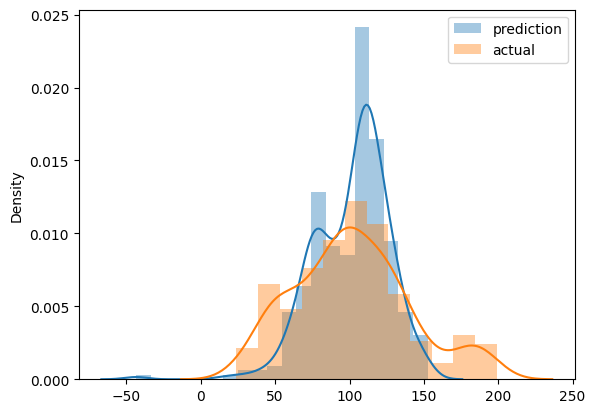

In [10]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [9]:
mlflow.set_experiment("airbnb-experiment")
mlflow.sklearn.autolog()

with mlflow.start_run():

    mlflow.set_tag("developer", "oliver")
    mlflow.log_param("train-data-path", "datasets/airbnb-listings-may.csv")
    mlflow.log_param("val-data-path", "datasets/airbnb-listings-june.csv")
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)
    
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    with open("models/lin_reg.bin", "wb") as f_out:
        pickle.dump(lr, f_out)
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

2024/07/28 18:29:07 INFO mlflow.tracking.fluent: Experiment with name 'airbnb-experiment' does not exist. Creating a new experiment.
2024/07/28 18:29:07 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2024/07/28 18:29:08 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'


### XGBoost

In [10]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [11]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [14]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [15]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:29.50105                          
[1]	validation-rmse:29.79577                          
[2]	validation-rmse:29.56101                          
[3]	validation-rmse:28.62318                          
[4]	validation-rmse:28.35727                          
[5]	validation-rmse:28.39886                          
[6]	validation-rmse:27.39796                          
[7]	validation-rmse:27.38703                          
[8]	validation-rmse:27.71683                          
[9]	validation-rmse:27.80596                          
[10]	validation-rmse:27.49299                         
[11]	validation-rmse:27.51790                         
[12]	validation-rmse:27.57519                         
[13]	validation-rmse:27.83820                         
[14]	validation-rmse:27.91941                         
[15]	validation-rmse:28.18064                         
[16]	validation-rmse:28.29649                         
[17]	validation-rmse:28.13396                         
[18]	valid

In [16]:
mlflow.xgboost.autolog(disable=True)

with mlflow.start_run():
    
    mlflow.set_tag("developer", "oliver")
    mlflow.log_param("train-data-path", "datasets/airbnb-listings-may.csv")
    mlflow.log_param("val-data-path", "datasets/airbnb-listings-june.csv")
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
        
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

[0]	validation-rmse:36.04995
[1]	validation-rmse:34.64846
[2]	validation-rmse:33.48183
[3]	validation-rmse:32.69584
[4]	validation-rmse:32.04908
[5]	validation-rmse:31.54993
[6]	validation-rmse:31.18200
[7]	validation-rmse:30.96145
[8]	validation-rmse:30.72317
[9]	validation-rmse:30.49955
[10]	validation-rmse:30.40726
[11]	validation-rmse:30.32743
[12]	validation-rmse:30.26791
[13]	validation-rmse:30.29633
[14]	validation-rmse:30.26653
[15]	validation-rmse:30.24214
[16]	validation-rmse:30.21247
[17]	validation-rmse:30.23653
[18]	validation-rmse:30.23235
[19]	validation-rmse:30.22032
[20]	validation-rmse:30.26356
[21]	validation-rmse:30.27924
[22]	validation-rmse:30.27724
[23]	validation-rmse:30.29739
[24]	validation-rmse:30.29717
[25]	validation-rmse:30.30737
[26]	validation-rmse:30.30606
[27]	validation-rmse:30.30539
[28]	validation-rmse:30.30691
[29]	validation-rmse:30.31768
[30]	validation-rmse:30.31806
[31]	validation-rmse:30.31691
[32]	validation-rmse:30.31476
[33]	validation-rmse

### Other

In [17]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.set_tag("developer", "oliver")
        mlflow.log_param("train-data-path", "datasets/airbnb-listings-may.csv")
        mlflow.log_param("val-data-path", "datasets/airbnb-listings-june.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

2024/07/28 18:50:28 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2024/07/28 18:50:28 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
2024/07/28 18:50:31 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
2024/07/28 18:50:33 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
2024/07/28 18:50:36 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'numpy.ndarray' object has no attribute 'toarray'
